In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [4]:
with open('names.txt','r') as h:
    words = [w.rstrip() for w in h.readlines()]

print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [5]:
chars = sorted(set(''.join(words)))
chars = ['.']+chars

#
# same result as two rows above as '.' is less than any [a-z] or [0-9]
#chars = sorted(set('.'.join(words)))

# same:
#chars = ['.']+[*chars]

N = len(chars)
print(f"\nTotal characters: {N=}\n")

stoi = { s:i for i,s in enumerate(chars)}
itos = { i:s for s,i in stoi.items()}

print(itos,'\n')

encode = lambda c : stoi[c]
decode = lambda i : itos[i]

print(encode('a'))
print(decode(1))


Total characters: N=27

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'} 

1
a


In [6]:
#
#  NTok is defaulted to 27 as this is the English char set plus '.'
#
def model_init(NTok=27, verbose=True):
    
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((NTok, 10), generator=g)

    Neurons = 200
    W1 = torch.randn((30, Neurons), generator=g)
    b1 = torch.randn(Neurons, generator=g)

    # map the 100-dim processing layer back to the tokens (NTok)
    # to get the prediction:
    W2 = torch.randn((Neurons, NTok), generator=g)
    b2 = torch.randn(NTok, generator=g)

    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
        
    total_parameters = sum([p.nelement() for p in parameters])
    
    if verbose:
        print(f"{total_parameters = }")
        
    return parameters

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = encode(ch)
            X.append(context)
            Y.append(ix)
            context = context[1:]+[ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

def forward_loss(X, Y, C, W1, b1, W2, b2):
    
    with torch.no_grad():
        emb = C[X]
        d = emb.shape[1]*emb.shape[2]
        h = torch.tanh(emb.view(-1,d) @ W1 + b1)
        logits = h @ W2 + b2
        logits.shape
        loss = F.cross_entropy(logits, Y)
        
        return loss.item()
    
def backward_loss(X, Y, C, W1, b1, W2, b2):
    
    emb = C[X]
    d = emb.shape[1]*emb.shape[2]
    h = torch.tanh(emb.view(-1,d) @ W1 + b1)
    logits = h @ W2 + b2
    logits.shape
    loss = F.cross_entropy(logits, Y)
    
    for p in parameters:
        p.grad = None
    
    loss.backward()

    return loss
    
def generate_sample(n, C, W1, b1, W2, b2):
    # sample from the resulting distribution
    res = []
    g = torch.Generator().manual_seed(2147483647+10)
    
    for _ in range(n):
        out=[]
        context = 3*[0]
        #     while True:
        # in case 0 never occurs:
        for _ in range(100):
            # forward pass
            emb = C[torch.tensor([context])]
            h = torch.tanh(emb.view(1,-1)) @ W1 + b1
            #print(h.shape)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            out.append(decode(ix))
            
            if ix == 0:
                break
    
        res.append(''.join(out))
    
    return res

In [7]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

random.seed(42)
random.shuffle(words)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [36]:
#
# step over a bunch of learning rates in log-space
#
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

S = lre.shape[0]

loss_v = torch.zeros(S)
parameters = model_init()

total_parameters = 11897


In [43]:
trials = 10
for step in range(S):
    lr = lrs[step]
    ll = torch.zeros(trials)
    for trial in range(trials):
    
        ix = torch.randint(0, Xtr.shape[0], (32,))
        loss = backward_loss(Xtr[ix], Ytr[ix], *parameters)
        
        for p in parameters:
            p.data -= lr*p.grad
            
        ll[trial] = loss.item()

    loss_v[step] = ll.mean()

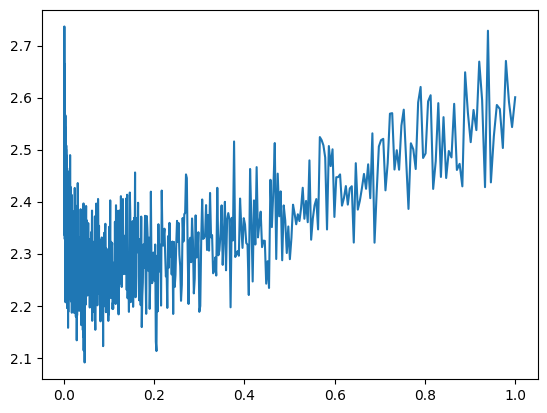

In [44]:
plt.plot(lrs, loss_v)

In [72]:
#
# step over a bunch of learning rates in log-space
#
lre = torch.linspace(-1.2,-0.2,1000)
lrs = 10**lre

S = lre.shape[0]

loss_v = torch.zeros(S)
parameters = model_init()

total_parameters = 11897


In [76]:
# make a single step
trials = 2
for step in range(S):
    lr = lrs[step]
    ll = torch.zeros(trials)
    for trial in range(trials):
    
        ix = torch.randint(0, Xtr.shape[0], (32,))
        loss = backward_loss(Xtr[ix], Ytr[ix], *parameters)
        
        for p in parameters:
            p.data -= lr*p.grad
         
        # store current loss value for the given batch
        # (defined by a random ix (32 values))
        ll[trial] = loss.item()

    loss_v[step] = ll.mean()

In [85]:
ix = torch.randint(0, Xtr.shape[0], (32,))
loss = backward_loss(Xtr[ix], Ytr[ix], *parameters)
print(f"before the gradient step: {loss.item() = }")

for p in parameters:
    p.data -= lr*p.grad
    # this will fail:
    # p -= lr*p.grad 
    # as p requires grad and cannot be modified in-place
    # but .data can, isn't this a bit odd?
    
print(f"after the gradient step with {lr = }, {loss.item() = }")

loss = backward_loss(Xtr[ix], Ytr[ix], *parameters)
print(f"after the gradient step with {lr = }, and loss.backward(): {loss.item() = }")

before the gradient step: loss.item() = 5.861292362213135
after the gradient step with lr = tensor(0.6310), loss.item() = 5.861292362213135
after the gradient step with lr = tensor(0.6310), and loss.backward(): loss.item() = 1.543332815170288


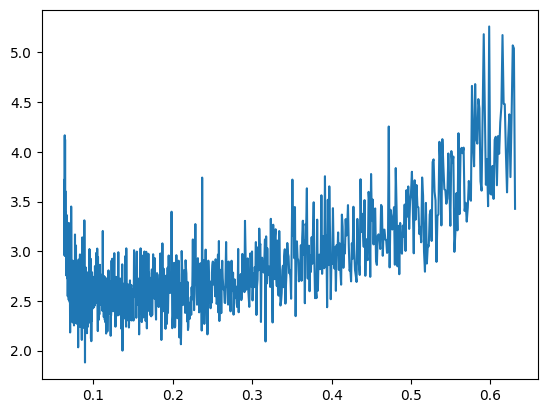

In [77]:
plt.plot(lrs, loss_v)

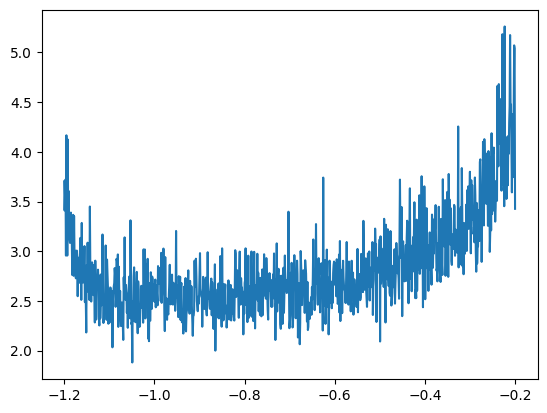

In [78]:
plt.plot(lre, loss_v)

In [71]:
C, W1, b1, W2, b2 = parameters = model_init()

total_parameters = 11897


In [962]:
Steps = 500000

for step in range(Steps):

    ix = torch.randint(0, Xtr.shape[0], (64,))
    emb = C[Xtr[ix]]    
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # (27, 1)
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    if step % int(Steps/10) == 0:
        print(f"{step = }, loss = {loss.item()}")
    lr = 0.1 if step < 100000 else 0.01 if step < 200000 else 0.001
    for p in parameters:
        p.data -= lr*p.grad
    
print(f"loss = {loss.item()}")
print(forward_loss(Xdev, Ydev, C, W1, b1, W2, b2))

step = 0, loss = 25.140933990478516
step = 50000, loss = 2.6446571350097656
step = 100000, loss = 1.9213510751724243
step = 150000, loss = 1.95083749294281
step = 200000, loss = 2.15459942817688
step = 250000, loss = 2.323143243789673
step = 300000, loss = 1.9021228551864624
step = 350000, loss = 2.3761212825775146
step = 400000, loss = 2.3216042518615723
step = 450000, loss = 2.305626630783081
loss = 2.131059408187866
2.1461055278778076


In [967]:
generate_sample(5, C, W1, b1, W2, b2)

['iaaaaiaaaiaiaaiiiiiiiiiiaiaaiaaaaaaiaaaauiaaaaaiaiaiiaaaiiaaaaaiaiaiaiiiiaaiaiiauaaiaiiiaiiaiauiaaai',
 'aaaiiaaiiiiaaiaaaiiaiiiiiaiauiiiuuaiiiaaiaiiaaaiaaaaaiaaaaaaaaaiaaaiiayaiiaaaiaiaiaaiaaaaiaiaiiaaiaa',
 'aaaaaaiuaaiaiaaiiaiaaiuiaiaaaiaiiaaaaaaiaaiaaaaiaiaaiaiayiaiaiuiaaiaaiaiauiaayaaiaaaaaiaaiiaauiiiaai',
 'aaiaiiaaaaaiaiaaaaeaaiiiaaaaiaiaaiaaiaaiaaaiaaiaaiaiiaiaaaaaiaiiaiaiiiiauaaaaiaiaiiyiiaiaiiuiaaaaaaa',
 'yiiiaayaaiiaaaaauaaaaiiiiaiaaiauaiaiiaiiiaaaiaaaaaiuaaaaiaiaiiauaaiiuaiaiaaaiaiuuiaaaiiiaaaaaaiaiaai']

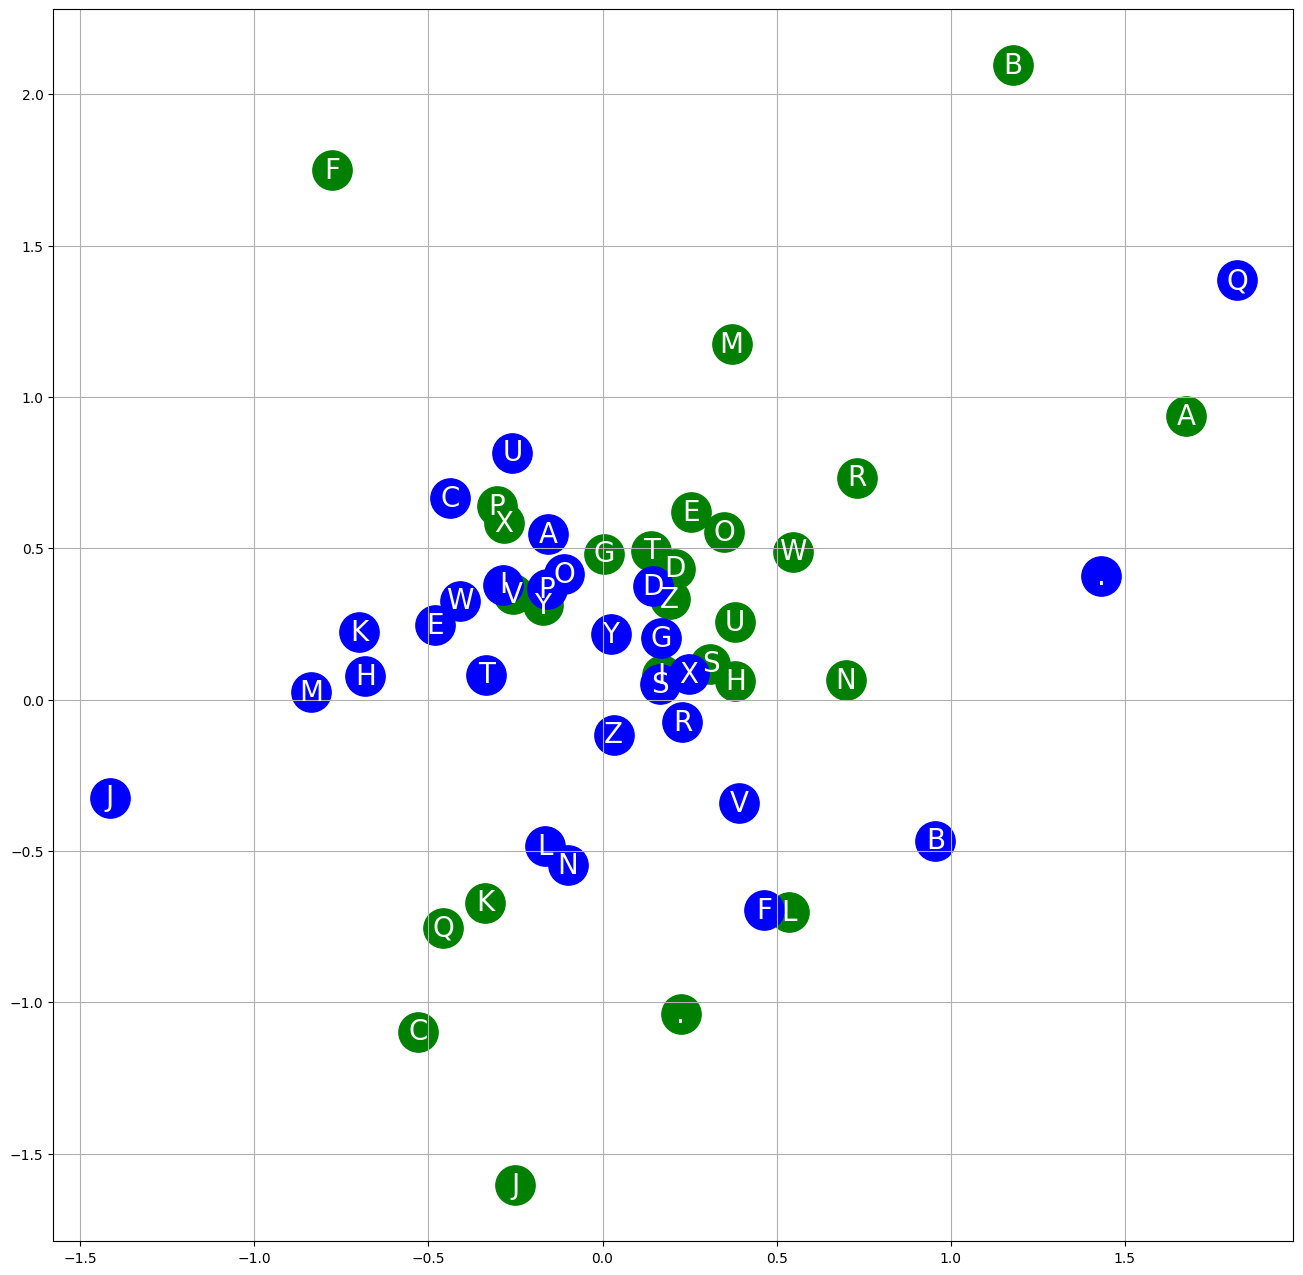

In [907]:
plt.figure(figsize=(16, 16))
plt.scatter(C[:,5].data, C[:,6].data, s=800, color='g')
plt.scatter(C[:,0].data, C[:,1].data, s=800, color='b')
for i in range(C.shape[0]):
    plt.text(C[i,5].item(), C[i,6].item(), decode(i).upper(), ha='center', va='center', color='white', size=20)
    plt.text(C[i,0].item(), C[i,1].item(), decode(i).upper(), ha='center', va='center', color='white', size=20)
plt.grid('minor')

In [908]:
# dev loss
emb_d = C[Xdev]
h = torch.tanh(emb_d.view(-1,30) @ W1 + b1)
print(h.shape)
logits = h @ W2 + b2
logits.shape
loss_d = F.cross_entropy(logits, Ydev)
print(loss_d.item())

torch.Size([22836, 200])
2.128429651260376


In [804]:
#
#  remarkably this is how changing context to [context]
#      changes the resulting tensor (by adding a dimention on the left)
#
print(f"{C[torch.tensor([[context]])].shape = }")
print(f"{C[torch.tensor([context])].shape = }")
print(f"{C[torch.tensor(context)].shape = }")

print(f"\n\n{C[torch.tensor(context)] = }")
print(f"{C[torch.tensor([context])] = }")

C[torch.tensor([[context]])].shape = torch.Size([1, 1, 3, 2])
C[torch.tensor([context])].shape = torch.Size([1, 3, 2])
C[torch.tensor(context)].shape = torch.Size([3, 2])


C[torch.tensor(context)] = tensor([[ 0.5187, -0.3240],
        [ 0.5187, -0.3240],
        [ 0.5187, -0.3240]], grad_fn=<IndexBackward0>)
C[torch.tensor([context])] = tensor([[[ 0.5187, -0.3240],
         [ 0.5187, -0.3240],
         [ 0.5187, -0.3240]]], grad_fn=<IndexBackward0>)


In [946]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1]])